In [ ]:
pip install --upgrade xgboost scikit-learn

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from xgboost import XGBRegressor

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Introduction #
The question we have is to help predict the scenarios by which road accidents are more likely to occur than others, and thereby giving a helpful model which can help us focus on making scenarios with features that are involved with higher likelihood risk safer.

Since we want to predict a continuous value between 0 and 1, we will use a regression model and in particular the XGBoost model. To begin, we will of course load the data and look at its properties to see how we need to pre process the data.

In [14]:
data_train_path = '/kaggle/input/playground-series-s5e10/train.csv'
data_test_path = '/kaggle/input/playground-series-s5e10/test.csv'

data_train = pd.read_csv(data_train_path)
data_test = pd.read_csv(data_test_path)

data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

# EDA #
Next we'll continue in this vain of looking at the data to better understand the data moving forward. This is a crucial step to understand the data's structure, relationships ( between the features and targets ), and find any potential issues. We'll start looking at the target variable to confirm what we've seen above.

In [15]:
target = 'accident_risk'
data_train[target].describe()

count    517754.000000
mean          0.352377
std           0.166417
min           0.000000
25%           0.230000
50%           0.340000
75%           0.460000
max           1.000000
Name: accident_risk, dtype: float64

<Axes: >

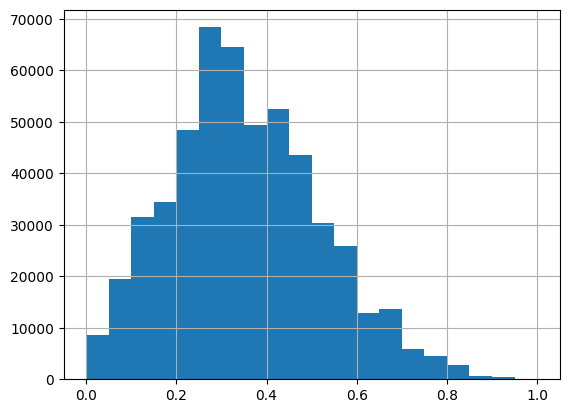

In [16]:
data_train[target].hist(bins = 20)

Next up let's look at the numerical features:

In [17]:
bool_features = ['road_signs_present', 'public_road', 'holiday', 'school_season']
num_features = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']

data_train[num_features].describe()

,num_lanes,curvature,speed_limit,num_reported_accidents
count,517754.000000,517754.000000,517754.000000,517754.000000
mean,2.491511,0.488719,46.112575,1.187970
std,1.120434,0.272563,15.788521,0.895961
min,1.000000,0.000000,25.000000,0.000000
25%,1.000000,0.260000,35.000000,1.000000
50%,2.000000,0.510000,45.000000,1.000000
75%,3.000000,0.710000,60.000000,2.000000
max,4.000000,1.000000,70.000000,7.000000


In [18]:
data_train[bool_features].describe()

,road_signs_present,public_road,holiday,school_season
count,517754,517754,517754,517754
unique,2,2,2,2
top,False,True,True,False
freq,259289,260045,260688,260164


Now let's look at the categorical features:

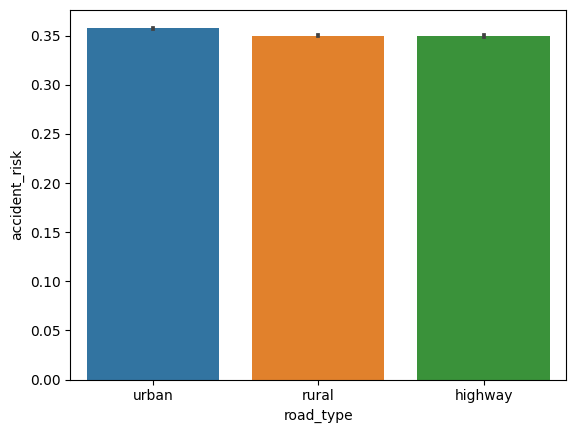

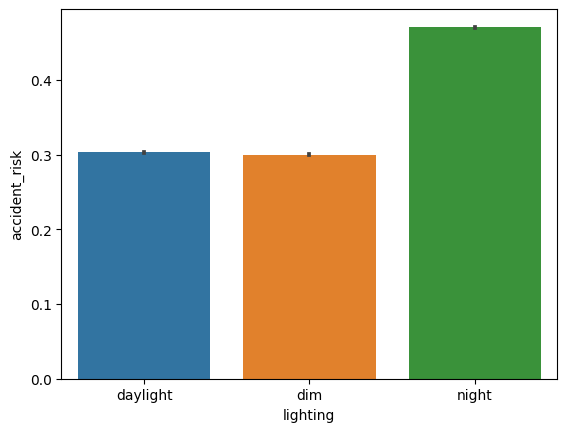

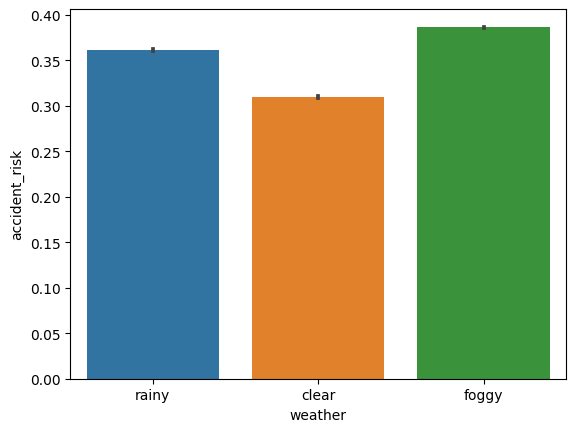

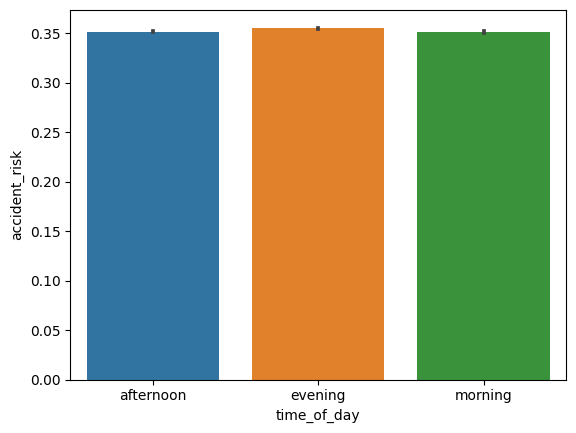

In [19]:
cat_features = ['road_type', 'lighting', 'weather', 'time_of_day']
for col in cat_features:
    sns.barplot(data = data_train, x = col, y = target)
    plt.show()

# Data Processing #
Since we now have a good idea of the data and the form of each feature, we can go ahead and start data processing. We are lucky here that there are no null values in all of the data which of course is not realistic, but lucky none the less! If we did have null values of course we would either drop that column ( if a substatial amount of nulls ), or most likely perform imputation with a valid replacement depending on which features nulls we were dealing with. 

Anyway, we must now focus on the different data types we have, and of course must deal with the bools and categories for our model to work. For the bools we will just change False = 0 and True = 1 ( as convention ), and for the categories we could enable_categorical for the XGBoost to recognise them as categories, but we will do OH encoding here using sklearns ColumnTransformer.

In [20]:
y_train = data_train[target]
x_train = data_train.drop(columns = ['id', target])

ids = data_test['id']
x_test = data_test.drop(columns = ['id'])

for col in bool_features:
    x_train[col] = x_train[col].astype(int)
    x_test[col] = x_test[col].astype(int)

features = num_features + bool_features

cat_transformer = Pipeline(steps = [
    ('OH', OneHotEncoder(handle_unknown = 'ignore', drop = 'first', sparse_output = False))
])

preproc = ColumnTransformer(
    transformers = [
        ('OH', cat_transformer, cat_features),
        ('pass', 'passthrough', features)
    ], 
    remainder = 'drop')

x_train_split, x_val, y_train_split, y_val = train_test_split(x_train, y_train, train_size = 0.8, test_size = 0.2, random_state = 1)

x_train_proc = preproc.fit_transform(x_train_split)
x_val_proc = preproc.transform(x_val)
x_test_proc = preproc.transform(x_test)


# Modelling #
Now that the data is fully processed, we can move onto the model! As mentioned above, we are using XGBoost for this task. As shown above we've already split that train data into processed training data, and then process validation data to use later. Next we just use the xgb regressor for our model, with suitable parameters as shown, and then fit our model to the training data.

In [21]:
model = xgb.XGBRegressor(
    objective = 'reg:squarederror',
    n_estimators = 1000,
    learning_rate = 0.05,
    max_depth = 5,
    subsample = 0.8,
    colsample_bytree = 0.8,
    n_jobs = -1,
    random_state = 2,
    early_stopping_rounds = 50
)

model.fit(x_train_proc, y_train_split,
    eval_set = [(x_val_proc, y_val)],
    verbose = 100
)

[0]	validation_0-rmse:0.15944
[100]	validation_0-rmse:0.05697
[200]	validation_0-rmse:0.05641
[300]	validation_0-rmse:0.05633
[400]	validation_0-rmse:0.05629
[500]	validation_0-rmse:0.05627
[600]	validation_0-rmse:0.05625
[700]	validation_0-rmse:0.05624
[800]	validation_0-rmse:0.05623
[900]	validation_0-rmse:0.05623
[999]	validation_0-rmse:0.05623


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=2, ...)

# Evaluation #
As we now have the model trained, it's time to evalute how well it performs to then see if we can make improvements in future etc. The competition evaluation metric is the root mean squared error, so that's how we'll evaluate! We predict the validation data for x and see how close it is to the true known target value.

In [22]:
predictions = model.predict(x_val_proc)
rmse = np.sqrt(mean_squared_error(y_val, predictions))
print(rmse)

0.05622632391130829


# Prediction and Conclusion #
Of course now since we are done, we take the processed test data and make our predictions for that! Then we of course must submit the predictions to the competition.

And there we go! The project is done! We've successfully predicted road accident risk for unknown data, and achieved a pretty good rmse of 0.056 for the validation data. Of course as we know this is never finished and can be improved apon with a number of methods from hyper-parameter tuning to advanced feature engineering, but it's a base to build from.

In [23]:
predictions = model.predict(x_test_proc)

sub = pd.DataFrame({'id': ids, 'accident_risk': predictions})
sub.to_csv('submission.csv', index = False)